The explanation for steps in this notebook is at https://youranalystbuddy.com/linear-regression-model/

## Full Regresion Model

### Loading and exploring data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('students1000.csv')

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 762 to 648
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          800 non-null    int64  
 1   FirstName          800 non-null    object 
 2   LastName           800 non-null    object 
 3   Major              800 non-null    object 
 4   HighSchoolGPA      800 non-null    float64
 5   FamilyIncome       800 non-null    int64  
 6   State              788 non-null    object 
 7   AvgDailyStudyTime  786 non-null    float64
 8   TotalAbsence       793 non-null    float64
 9   FirstYearGPA       800 non-null    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 68.8+ KB


In [4]:
num_cols = ['HighSchoolGPA','FamilyIncome','AvgDailyStudyTime','TotalAbsence']
cat_cols = ['Major', 'State']
target = 'FirstYearGPA'

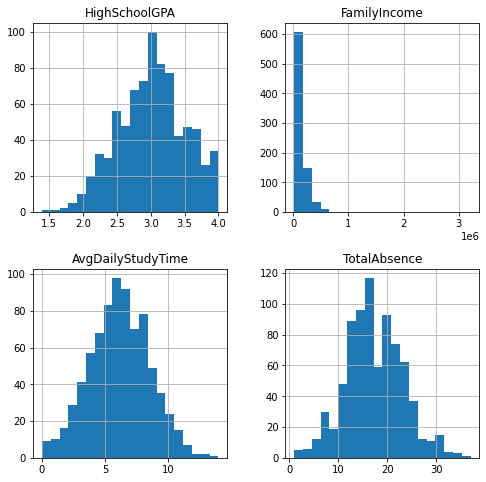

In [5]:
import matplotlib.pyplot as plt

train[num_cols].hist(bins=20, figsize=(8,8))
plt.show()

Major


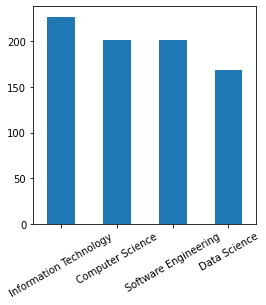

State


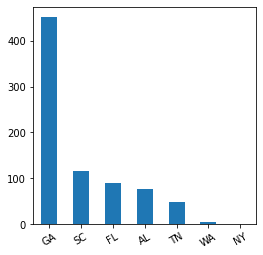

In [6]:
for col in cat_cols:
    print(col)
    train[col].value_counts().plot.bar(rot=30, figsize=(4,4))
    plt.show()

<h3>Processing Pipeline</h3>

In [7]:
log_cols = ['FamilyIncome']
num_cols = ['HighSchoolGPA','AvgDailyStudyTime','TotalAbsence']
cat_cols = ['Major','State']

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#regular pipeline for HighSchoolGPA, AvgDailyStudyTime, and TotaAbsence
num_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

#log pipeline with log transformation added for FamilyIncome
def log_transform(data):
    return np.log(data)

log_pipeline = Pipeline([
    ('log transform', FunctionTransformer(log_transform)),
    ('standardize', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

#categorical pipeline for Major and State
cat_pipeline = Pipeline([
    ('encode', OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist'))
])

#combine all in a single pipeline

processing_pipeline = ColumnTransformer([
    ('log trans', log_pipeline, log_cols),
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

<h3>Regression Model</h3>

<h4>Create and train model</h4>

In [8]:
from sklearn.linear_model import LinearRegression

linear_reg_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('modeling', LinearRegression())
])

linear_reg_pipeline.fit(train, train[[target]])

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('log trans',
                                                  Pipeline(steps=[('log '
                                                                   'transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000017905B373A0>)),
                                                                  ('standardize',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['FamilyIncome']),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['HighSchoolGPA',
                                                   'AvgDailyStudyTime',
                                                   'TotalAbsence']),
                                                 ('class',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=5))]),
                                                  ['Major', 'State'])])),
                ('modeling', LinearRegression())])

#### Model evaluation

Getting MSE

In [9]:
from sklearn.metrics import mean_squared_error

#get the prediction
trainY_pred = linear_reg_pipeline.predict(train)

#get the MSE
mse_lr = mean_squared_error(train[[target]], trainY_pred)
print(mse_lr)

0.04336001595092426


Lower MSE means better more accurate models. However, **do not compare MSE of models trained on different data**.

A very similar metric is Root Mean Squared Error - RMSE which is the square root of the MSE

In [10]:
np.sqrt(mse_lr)

0.20823067965822006

RMSE is intepreted as the average errors between the predicted values and the true values, in this case, the predicted first year GPA and the true first year GPA of the students.

Is this a good model? Recall, the range of GPA is from 0 - 4 (or in this data, 2.0 - 4.15), so is an average error of 0.381 good enough?

Measurements like MSE and RMSE are dependent on the target range, and could be hard to interprete sometimes. We can use a different measurement that is the R-Squared

In [11]:
from sklearn.metrics import r2_score

r2_lr = r2_score(train[[target]], trainY_pred)
print(r2_lr)

0.8578342151552371


R2 score is always less than 1, and it is interpreted as the percentage of variation in the data that our model can explain. In cases with very bad-fit models, R2 can get to negative values.

In this case, this linear regression model can explain about 81% variation in the data.

#### Inference on test data 

Now we can see how the model adapt to new data, i.e., the test set

In [12]:
#get the MSE
testY_pred = linear_reg_pipeline.predict(test)

mse_lr_test = mean_squared_error(test[[target]], testY_pred)
print(mse_lr_test)

0.041509744923245606


In [13]:
r2_lr_test = r2_score(test[[target]], testY_pred)
print(r2_lr_test)

0.8464113906421408
